In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import os
import random
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from ibug import IBUGWrapper
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
import logging
import time 
import yaml
import cohere
import seaborn as sns
import json
import glob
import re

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# GPR-UCB

In [ ]:
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e6))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        print("Selected kernel after optimization:", self.model.kernel_)

    def select_next_point(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        ucb = mean + self.alpha * std
        return np.argmax(ucb), ucb, mean, std

def run_gpr_ucb(X_df, y_df, target_name, dataset_name, alpha=1.0, random_seed=42):
    X = X_df.values
    y = y_df.values
    max_target = y.max()

    random.seed(random_seed)
    np.random.seed(random_seed)

    initial_idx = random.choice(list(range(len(X))))
    X_train_ucb = X[[initial_idx]]
    y_train_ucb = np.array([y[initial_idx]])

    model_ucb = ActiveLearningUCB(alpha=alpha, random_state=random_seed)

    selected_ucb = [initial_idx]
    obs_ucb = [y[initial_idx]]
    mean_predictions_ucb = []
    std_predictions_ucb= []
    iteration_indices = [0]
    trajectory_data = []

    for i, _ in enumerate(range(len(X) - 1)):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_ucb)
        
        model_ucb.update_model(X_train_scaled, y_train_ucb)

        available = list(set(range(len(X))) - set(selected_ucb))
        if not available:
            break
        X_candidates_scaled = scaler.transform(X[available])

        idx_ucb, ucb_scores, mean_ucb, std_ucb = model_ucb.select_next_point(X_candidates_scaled)
        next_idx_ucb = available[idx_ucb]
        selected_ucb.append(next_idx_ucb)
        obs_ucb.append(y[next_idx_ucb])
        X_train_ucb = np.vstack([X_train_ucb, X[[next_idx_ucb]]])
        y_train_ucb = np.append(y_train_ucb, y[next_idx_ucb])

        mean_predictions_ucb.append(mean_ucb[idx_ucb])
        std_predictions_ucb.append(std_ucb[idx_ucb])
        iteration_indices.append(i+1)

        trajectory_data.append({
            "Iteration": i+1,
            "UCB Index": next_idx_ucb,
            "Observed UCB": y[next_idx_ucb],
            "Predicted UCB": mean_ucb[idx_ucb],
            "Uncertainty UCB": std_ucb[idx_ucb],
            f"Max {target_name} in Dataset": max_target,
            "Stopping Reason": f"Max {target_name} reached" if y[next_idx_ucb] >= max_target else "Continuing"
        })

        if y[next_idx_ucb] >= max_target:
            print(f"Stopping early at iteration {i+1} - Max {target_name} found.")
            break

    df_traj = pd.DataFrame(trajectory_data)
    os.makedirs(f"al_trajectory_data_all/{dataset_name}", exist_ok=True)
    file_path = f"al_trajectory_data_all/{dataset_name}/gpr-ucb_experiment_trajectory_{dataset_name}_composition_alpha{alpha}_seed{random_seed}.csv"
    df_traj.to_csv(file_path, index=False)
    print(f"Saved trajectory data to {file_path}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(obs_ucb)), obs_ucb, marker='o', label=f"Observed {target_name}(alpha={alpha})")
    plt.fill_between(iteration_indices[1:], np.array(mean_predictions_ucb) - np.array(std_predictions_ucb),
                     np.array(mean_predictions_ucb) + np.array(std_predictions_ucb),
                     color="gray", alpha=0.3, label="Uncertainty")
    plt.plot(iteration_indices[1:], mean_predictions_ucb, linestyle='--', color="gray", label=f"Predicted {target_name}")
    plt.axhline(max_target, color='r', linestyle='--', label=f'Max {target_name}')
    plt.xlabel("Iteration")
    plt.ylabel(target_name)
    plt.title(f"Comparison of UCB for Active Learning (Seed={random_seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
data_grouped = pd.read_csv('steels_yield_report_featurized.csv')
X_df = data_grouped.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore')
X_df = X_df.select_dtypes(include=[np.number]).iloc[:, 14:]
y_df = data_grouped['yield strength']

In [ ]:
X_df = data_grouped.iloc[:, 2:16]

In [ ]:
for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
    for seed in [42, 41, 40, 39, 38]:
        run_gpr_ucb(X_df= X_df, y_df=y_df, target_name='Yield Strength', dataset_name='matbench_steels',
                    alpha=alpha, random_seed=seed)

# GPR-EI

In [ ]:
class ActiveLearningEI:
    def __init__(self, kernel=None, xi=0.01, random_state=42):
        self.xi = xi
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e6))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        print("Selected kernel after optimization:", self.model.kernel_)

    def select_next_point(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        std = np.maximum(std, 1e-9)
        y_best = np.max(self.model.y_train_)
        improvement = mean - y_best - self.xi
        Z = improvement / std
        ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
        ei[std == 0.0] = 0.0
        return np.argmax(ei), ei, mean, std

def run_gpr_ei(X_df, y_df, target_name, dataset_name, xi=0.01, random_seed=42):
    X = X_df.values
    y = y_df.values
    max_target = y.max()

    random.seed(random_seed)
    np.random.seed(random_seed)

    initial_idx = random.choice(list(range(len(X))))
    X_train_ei = X[[initial_idx]]
    y_train_ei = np.array([y[initial_idx]])

    model_ei = ActiveLearningEI(xi=xi, random_state=random_seed)

    selected_ei = [initial_idx]
    obs_ei = [y[initial_idx]]
    mean_predictions_ei = []
    std_predictions_ei = []
    iteration_indices = [0]
    trajectory_data = []

    for i, _ in enumerate(range(len(X) - 1)):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_ei)

        model_ei.update_model(X_train_scaled, y_train_ei)

        available = list(set(range(len(X))) - set(selected_ei))
        if not available:
            break
        X_candidates_scaled = scaler.transform(X[available])

        idx_ei, ei_scores, mean_ei, std_ei = model_ei.select_next_point(X_candidates_scaled)
        next_idx_ei = available[idx_ei]
        selected_ei.append(next_idx_ei)
        obs_ei.append(y[next_idx_ei])
        X_train_ei = np.vstack([X_train_ei, X[[next_idx_ei]]])
        y_train_ei = np.append(y_train_ei, y[next_idx_ei])

        mean_predictions_ei.append(mean_ei[idx_ei])
        std_predictions_ei.append(std_ei[idx_ei])
        iteration_indices.append(i+1)

        trajectory_data.append({
            "Iteration": i+1,
            "EI Index": next_idx_ei,
            "Observed EI": y[next_idx_ei],
            "Predicted EI": mean_ei[idx_ei],
            "Uncertainty EI": std_ei[idx_ei],
            f"Max {target_name} in Dataset": max_target,
            "Stopping Reason": f"Max {target_name} reached" if y[next_idx_ei] >= max_target else "Continuing"
        })

        if y[next_idx_ei] >= max_target:
            print(f"Stopping early at iteration {i+1} - Max {target_name} found.")
            break

    df_traj = pd.DataFrame(trajectory_data)
    os.makedirs(f"al_trajectory_data_all/{dataset_name}", exist_ok=True)
    file_path = f"al_trajectory_data_all/{dataset_name}/gpr-ei_experiment_trajectory_{dataset_name}_composition_xi{xi}_seed{random_seed}.csv"
    df_traj.to_csv(file_path, index=False)
    print(f"Saved trajectory data to {file_path}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(obs_ei)), obs_ei, marker='s', label=f"Observed {target_name}(xi={xi})")
    plt.fill_between(iteration_indices[1:], np.array(mean_predictions_ei) - np.array(std_predictions_ei),
                     np.array(mean_predictions_ei) + np.array(std_predictions_ei),
                     color="blue", alpha=0.3, label="Uncertainty EI")
    plt.plot(iteration_indices[1:], mean_predictions_ei, linestyle='--', color="blue", label=f"Predicted {target_name} using EI")
    plt.axhline(max_target, color='r', linestyle='--', label=f'Max {target_name}')
    plt.xlabel("Iteration")
    plt.ylabel(target_name)
    plt.title(f"Comparison of EI for Active Learning (Seed={random_seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
for xi in [0, 0.01, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
    for seed in [42, 41, 40, 39, 38]:
        run_gpr_ei(X_df=X_df, y_df=y_df, target_name='Yield Strength', dataset_name='matbench_steels', xi=xi, random_seed=seed)

In [ ]:
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_iteration_to_max(data_dir, dataset_name, target_name, output_metric_name="Iteration to Max", show_plot=True):
    """
    Load and compare trajectory data for any model-acquisition method across seeds for a given dataset and target.

    Args:
        data_dir (str): Directory containing the trajectory CSV files.
        dataset_name (str): Subdirectory under data_dir, e.g., "matbench_steels".
        target_name (str): Target variable name, e.g., "yield_strength".
        output_metric_name (str): Label for the y-axis.
        show_plot (bool): Whether to show the plot immediately.
    """

    # General pattern: <model>-<acq>_experiment_trajectory_<dataset_name>_(featurized|composition)_alpha/xi<val>_seed<num>.csv
    general_pattern = re.compile(
        rf"([a-zA-Z0-9]+)-([a-zA-Z0-9]+)_experiment_trajectory_{dataset_name}_(featurized|composition)_(?:alpha|xi)?([\d\.]+)_seed(\d+)\.csv"
    )

    # LLM-specific pattern
    llm_pattern = re.compile(
        rf"llm_experiment_{target_name}_trajectory_(\w+)_seed(\d+)\.csv"
    )

    csv_files = glob.glob(os.path.join(data_dir, dataset_name, "*.csv"))
    results = []

    for file in csv_files:
        df = pd.read_csv(file)

        # General model-acquisition methods (e.g., gpr-ucb, xgb-ei, etc.)
        match_general = general_pattern.search(file)
        if match_general:
            model = match_general.group(1).upper()
            acq = match_general.group(2).upper()
            representation = match_general.group(3)
            param = float(match_general.group(4))
            seed = int(match_general.group(5))

            # Adjust for actual known column names
            if acq == "UCB":
                obs_col = "Observed UCB"
            elif acq == "EI":
                obs_col = "Observed EI"
            else:
                obs_col = f"Observed {target_name}"

            max_col = "Max Yield Strength in Dataset"  # Known constant from your files

            if max_col in df.columns and obs_col in df.columns:
                max_val = df[max_col].iloc[0]
                reached = df[df[obs_col] >= max_val]
                iter_to_max = reached['Iteration'].iloc[0] if not reached.empty else df['Iteration'].max()
                results.append({
                    "Method": f"{model}-{acq}",
                    "Param": param,
                    "Seed": seed,
                    "Subtype": representation,
                    "Iteration_to_Max": iter_to_max
                })

        # LLM methods
        match_llm = llm_pattern.search(file)
        if match_llm:
            subtype = match_llm.group(1)
            seed = int(match_llm.group(2))

            obs_col = "Observed Yield Strength"
            max_col = "Max Yield Strength in Dataset"

            if obs_col in df.columns and max_col in df.columns:
                max_val = df[max_col].iloc[0]
                reached = df[df[obs_col] >= max_val]
                iter_to_max = reached['Iteration'].iloc[0] if not reached.empty else df['Iteration'].max()
                results.append({
                    "Method": "LLM",
                    "Param": -1,
                    "Seed": seed,
                    "Subtype": subtype,
                    "Iteration_to_Max": iter_to_max
                })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        raise ValueError("No data found. Check dataset name, target, or directory.")

    # === Label formatting ===
    # === Label formatting with representation included ===
    def make_label(row):
        rep = row['Subtype']  # 'composition' or 'featurized'
        if row['Method'] == 'LLM':
            return f"LLM ({rep})"
        elif "UCB" in row['Method']:
            return f"{row['Method']} ({rep}) α={row['Param']:.1f}"
        elif "EI" in row['Method']:
            return f"{row['Method']} ({rep}) ξ={row['Param']:.2f}"
        else:
            return f"{row['Method']} ({rep}) Param={row['Param']:.2f}"


    results_df['Label'] = results_df.apply(make_label, axis=1)

    # === Sort labels ===
    llm_labels = sorted(results_df[results_df['Method'] == 'LLM']['Label'].unique())
    other_labels = sorted(
        results_df[results_df['Method'] != 'LLM']['Label'].unique(),
        key=lambda x: float(re.search(r"[αξ=]([\d\.]+)", x).group(1)) if re.search(r"[αξ=]([\d\.]+)", x) else 999
    )
    label_order = llm_labels + other_labels

    # === Plot ===
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Label', y='Iteration_to_Max', data=results_df, order=label_order,
                palette=sns.color_palette("Set2", len(label_order)))
    sns.stripplot(x='Label', y='Iteration_to_Max', data=results_df, hue='Seed',
                  dodge=True, jitter=True, linewidth=1, edgecolor='gray', order=label_order)

    plt.xticks(rotation=30, fontsize=13, ha='right')
    plt.xlabel("")
    plt.ylabel(output_metric_name, fontsize=14)
    plt.title(f"Iterations to Reach Max {target_name} ({dataset_name})", fontsize=16)
    plt.legend(title="Seed", loc='upper right')
    plt.tight_layout()

    if show_plot:
        plt.show()


In [ ]:
plot_iteration_to_max(
    data_dir="al_trajectory_data_all",      # root folder
    dataset_name="matbench_steels",         # subfolder under data_dir
    target_name="yield_strength",           # column name used in the trajectory CSVs
    output_metric_name="Iterations to Reach Max Yield Strength",  # optional y-axis label
    show_plot=True                          # set to False if you only want to prepare the plot
)

# Master Code

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import os
import random
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from ibug import IBUGWrapper
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
# ignore warnings
import warnings
warnings.filterwarnings("ignore")



class GPR:
    def __init__(self, kernel=None, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e6))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def select_next_point(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        ucb = mean + self.alpha * std
        return np.argmax(ucb), ucb, mean, std

class RFR:
    def __init__(self,n_estimators=400, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def rfPredictionIntervals(self, xVal, percentile=90):
        # initialize a list to hold the predictions from each tree
        y_preds = []
        # loop through the trees in the random forest
        for tree in self.model.estimators_:
            # get the predictions from each tree
            y_pred = tree.predict(xVal)
            # append the predictions to the list
            y_preds.append(y_pred)
        # Convert to np.array by stacking list of arrays along the column axis with each column being the prediction from a different tree
        y_preds = np.stack(y_preds, axis=1)           
        # get the quantiles for the confidence interval
        q_down = (100 - percentile) / 2.
        q_up = 100 - q_down

        # get the mean, uncertainty, lower bound, and upper bound
        y_lower = np.percentile(y_preds, q_down, axis=1)
        y_upper = np.percentile(y_preds, q_up, axis=1)  
        y_mean = self.model.predict(xVal)  
        y_uncert = y_upper - y_lower
        
        return y_mean, y_uncert


    def select_next_point(self, X_candidates):
        mean, uncertainty = self.rfPredictionIntervals(X_candidates)
        ucb = mean + self.alpha * uncertainty
        return np.argmax(ucb), ucb, mean, uncertainty

class XGB:
    def __init__(self, n_estimators=400, n_models=30, alpha = 1.0, random_state=42):
        self.alpha = alpha
        self.n_models = n_models
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def update_model(self, X_train, y_train):
        self.models = []
        rng = np.random.RandomState(self.random_state)
        for i in range(self.n_models):
            X_sample, y_sample = resample(X_train, y_train, random_state=rng.randint(0, 10000))
            model = XGBRegressor(
                n_estimators=self.n_estimators,
                reg_alpha=0,
                scale_pos_weight=1,
                base_score=0.5,
                random_state=rng.randint(0, 10000)
            )
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def select_next_point(self, X_candidates):
        # Predict with all models
        y_preds = np.column_stack([model.predict(X_candidates) for model in self.models])

        # Compute uncertainty and mean
        y_mean = np.mean(y_preds, axis=1)
        y_std = np.std(y_preds, axis=1)
        ucb = y_mean + self.alpha * y_std
        return np.argmax(ucb), ucb, y_mean, y_std


#-------------------------------------------------------------------------------- BAYESIAN NEURAL NETWORK -------------------------------------------------------------------------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters for weights and biases
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5.0))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).fill_(-5.0))

        # Prior
        self.prior = Normal(0, 1)
        self.normal = Normal(0, 1)

    def forward(self, x):
        device = x.device

        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        # Create ε ~ N(0, 1) on the correct device
        weight_eps = torch.randn_like(self.weight_mu, device=device)
        bias_eps = torch.randn_like(self.bias_mu, device=device)

        weight = self.weight_mu + weight_sigma * weight_eps
        bias = self.bias_mu + bias_sigma * bias_eps

        return F.linear(x, weight, bias)


    def kl_loss(self):
        # Posterior: N(mu, sigma^2), Prior: N(0, 1)
        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        weight_kl = (torch.log(1.0 / weight_sigma) + (weight_sigma ** 2 + self.weight_mu ** 2 - 1) / 2).sum()
        bias_kl = (torch.log(1.0 / bias_sigma) + (bias_sigma ** 2 + self.bias_mu ** 2 - 1) / 2).sum()
        return weight_kl + bias_kl


class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.layers = nn.ModuleList([
            BayesianLinear(input_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
        ])
        self.out = BayesianLinear(hidden_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.out(x)

    def kl_loss(self):
        return sum(layer.kl_loss() for layer in self.layers) + self.out.kl_loss()


def elbo_loss(predictions, targets, kl, beta=1.0):
    mse = F.mse_loss(predictions.squeeze(), targets, reduction='mean')
    return mse + beta * kl


def train_bnn(model, X_train, y_train, n_epochs=1000, lr=1e-3, beta=1.0, batch_size=64, device='cpu'):
    # Create DataLoader for batching
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        total_kl = 0.0
        total_batches = 0

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            kl = model.kl_loss()
            loss = elbo_loss(preds, y_batch, kl, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_kl += kl.item()
            total_batches += 1

        if epoch % 100 == 0:
            avg_loss = total_loss / total_batches
            avg_kl = total_kl / total_batches
            print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Avg KL: {avg_kl:.2f}")


def predict_with_uncertainty(model, X, n_samples=1000):
    model.eval()
    #with torch.no_grad():
    preds = torch.stack([model(X).detach().squeeze() for _ in range(n_samples)])

    mean = preds.mean(0).cpu().numpy()
    std = preds.std(0).cpu().numpy()
    return mean, std

#-------------------------------------------------------------------------------- END CODE BAYESIAN NEURAL NETWORK -------------------------------------------------------------------------------------------


class BNN:
    def __init__(self, input_dim,device='cpu', alpha=1.0):
        self.alpha = alpha
        self.device=device
        self.model= BayesianNN(input_dim=input_dim).to(self.device)

    def update_model(self, X_train, y_train):
        X_train_tensor=torch.from_numpy(X_train).float().to(self.device)
        y_train_tensor=torch.from_numpy(y_train).float().to(self.device)
        train_bnn(self.model,X_train_tensor, y_train_tensor, batch_size=64,device=self.device)

    def select_next_point(self, X_candidates):
        X_candidates_tensor=torch.from_numpy(X_candidates).float().to(self.device)
        mean, std = predict_with_uncertainty(self.model,X_candidates_tensor)
        ucb = mean + self.alpha * std
        return np.argmax(ucb), ucb, mean, std





def run_MLAL(X_df, y_df, model_name, target_name, dataset_name, alpha=1.0, random_seed=42):
    X = X_df.values
    y = y_df.values
    max_target = y.max()

    num_col=X.shape[1]

    random.seed(random_seed)
    np.random.seed(random_seed)

    initial_idx = random.choice(list(range(len(X))))
    X_train = X[[initial_idx]]
    y_train = np.array([y[initial_idx]])

    if model_name == "GPR":
        model = GPR(alpha=alpha, random_state=random_seed)
    elif model_name == "RFR":
        model = RFR(alpha=alpha, random_state=random_seed)
    elif model_name == "XGB":
        model = XGB(alpha=alpha, random_state=random_seed)
    elif model_name == "BNN":
        model = BNN(num_col, alpha=alpha, device='cuda' if torch.cuda.is_available() else 'cpu')
    else:
        raise ValueError("Invalid model name. Choose from 'GPR', 'RFR', 'XGB', or 'BNN'.")
    

    # Indices of selected points
    selected = [initial_idx]
    # Observed values
    observed = [y[initial_idx]]
    # Mean predictions over all candidates
    mean_predictions = []
    # Uncertainty estimates
    uncertaintites = []

    iteration_indices = [0]
    trajectory_data = []

    for i, _ in enumerate(range(len(X) - 1)):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model.update_model(X_train_scaled, y_train)

        available = list(set(range(len(X))) - set(selected))

        X_candidates_scaled = scaler.transform(X[available])


        idx, ucb_scores, mean, uncertaintity = model.select_next_point(X_candidates_scaled)
        next_idx = available[idx]
        selected.append(next_idx)
        observed.append(y[next_idx])
        X_train = np.vstack([X_train, X[[next_idx]]])
        y_train= np.append(y_train, y[next_idx])

        mean_predictions.append(mean[idx])
        uncertaintites.append(uncertaintity[idx])

        iteration_indices.append(i+1)

        trajectory_data.append({
            "Iteration": i+1,
            "Index": next_idx,
            "Observed Target Value": y[next_idx],
            "Predicted Target Value": mean[idx],
            "Uncertainty": uncertaintity[idx],
            f"Max {target_name} in Dataset": max_target,
            "Stopping Reason": f"Max {target_name} reached" if y[next_idx] >= max_target else "Continuing"
        })

        if y[next_idx] >= max_target:
            print(f"Stopping early at iteration {i+1} - Max {target_name} found.")
            break

    df_traj = pd.DataFrame(trajectory_data)
    os.makedirs(f"al_trajectory_data_all/{dataset_name}", exist_ok=True)
    file_path = f"al_trajectory_data_all/{dataset_name}/{model_name}_trajectory_{dataset_name}_alpha{alpha}_seed{random_seed}.csv"
    df_traj.to_csv(file_path, index=False)
    print(f"Saved trajectory data to {file_path}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(observed)), observed, marker='o', label=f"Observed with {model_name} (alpha={alpha})")
    plt.fill_between(iteration_indices[1:], np.array(mean_predictions) - np.array(uncertaintites),
                     np.array(mean_predictions) + np.array(uncertaintites),
                     color="gray", alpha=0.3, label=f"Uncertainty {model_name}")
    plt.plot(iteration_indices[1:], mean_predictions, linestyle='--', color="gray", label=f"Predicted Strength using {model_name}")


    plt.axhline(max_target, color='r', linestyle='--', label=f'Max {target_name}')
    plt.xlabel("Iteration")
    plt.ylabel(target_name)
    plt.title(f"{model_name} Active Learning Trajectory (Alpha = {alpha}; Seed={random_seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# matbench_steels

## Composition

In [ ]:
data_grouped = pd.read_csv('steels_yield_report_featurized.csv')
X_df = data_grouped.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore')
#X_df = X_df.select_dtypes(include=[np.number]).iloc[:, 14:]
X_df = data_grouped.iloc[:, 2:16]
y_df = data_grouped['yield strength']

In [ ]:
for model_name in ["GPR", "RFR", "XGB", "BNN"]:
    for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
        for seed in [42, 41, 40, 39, 38]:
            run_MLAL(X_df, y_df, model_name=model_name, target_name="Yield Strength", dataset_name="matbench_steels (composition)", alpha=alpha, random_seed=seed)

## Featurized

In [ ]:
data_grouped = pd.read_csv('steels_yield_report_featurized.csv')
X_df = data_grouped.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore')
X_df = X_df.select_dtypes(include=[np.number]).iloc[:, 14:]
#X_df = data_grouped.iloc[:, 2:16]
y_df = data_grouped['yield strength']

In [ ]:
for model_name in ["GPR", "RFR", "XGB", "BNN"]:
    for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
        for seed in [42, 41, 40, 39, 38]:
            run_MLAL(X_df, y_df, model_name=model_name, target_name="Yield Strength", dataset_name="matbench_steels (featurized)", alpha=alpha, random_seed=seed)

In [2]:
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_iteration_to_max(data_dir, dataset_name, target_name, output_metric_name="Iteration to Max", show_plot=True):
    """
    Plot iterations to reach max target value for multiple models (including LLM) across seeds.
    """

    # For standard models
    model_pattern = re.compile(
        rf"([A-Za-z0-9]+)_trajectory_{re.escape(dataset_name)}_alpha([\d\.]+)_seed(\d+)\.csv"
    )

    # For LLM-style files: llm_experiment_<target>_trajectory_<variant>_seed<val>.csv
    llm_pattern = re.compile(
        r"llm_experiment_.*_trajectory_(parameters|report)_seed(\d+)\.csv"
    )

    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    results = []

    for file in csv_files:
        filename = os.path.basename(file)

        # Match standard model files
        match_model = model_pattern.search(filename)
        if match_model:
            model, alpha, seed = match_model.groups()
            alpha = float(alpha)
            seed = int(seed)

            df = pd.read_csv(file)
            max_col = f"Max {target_name} in Dataset"
            obs_col = "Observed Target Value"

            if max_col in df.columns and obs_col in df.columns:
                max_val = df[max_col].iloc[0]
                reached = df[df[obs_col] >= max_val]
                iter_to_max = reached['Iteration'].iloc[0] if not reached.empty else df['Iteration'].max()

                results.append({
                    "Method": model.upper(),
                    "Param": alpha,
                    "Seed": seed,
                    "Iteration_to_Max": iter_to_max
                })
            continue

        # Match LLM files (with parameters/report distinction)
        match_llm = llm_pattern.search(filename)
        if match_llm:
            variant, seed = match_llm.groups()
            seed = int(seed)
            df = pd.read_csv(file)
            results.append({
                "Method": f"LLM ({variant})",
                "Param": -1,
                "Seed": seed,
                "Iteration_to_Max": df['Iteration'].max()
            })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        raise ValueError("No valid data found. Check your directory and filenames.")

    # Label formatting
    def make_label(row):
        if row['Method'].startswith("LLM"):
            return row['Method']
        else:
            return f"{row['Method']} α={row['Param']:.1f}"

    results_df['Label'] = results_df.apply(make_label, axis=1)

    # Sorting: LLM first (parameters, report), then other models sorted by name + alpha
    llm_labels = sorted([label for label in results_df['Label'].unique() if label.startswith("LLM")])
    other_labels = sorted(
        [label for label in results_df['Label'].unique() if not label.startswith("LLM")],
        key=lambda x: (
            re.match(r"([A-Z]+)", x).group(1),
            float(re.search(r"α=([\d\.]+)", x).group(1)) if re.search(r"α=([\d\.]+)", x) else 999
        )
    )
    label_order = llm_labels + other_labels

    # Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Label', y='Iteration_to_Max', data=results_df, order=label_order,
                palette=sns.color_palette("Set2", len(label_order)))
    sns.stripplot(x='Label', y='Iteration_to_Max', data=results_df, hue='Seed',
                  dodge=True, jitter=True, linewidth=1, edgecolor='gray', order=label_order)

    plt.xticks(rotation=30, fontsize=13, ha='right')
    plt.xlabel("")
    plt.ylabel(output_metric_name, fontsize=14)
    plt.title(f"Iterations to Reach Max {target_name} ({dataset_name})", fontsize=16)
    plt.legend(title="Seed", loc='upper right')
    plt.tight_layout()

    if show_plot:
        plt.show()


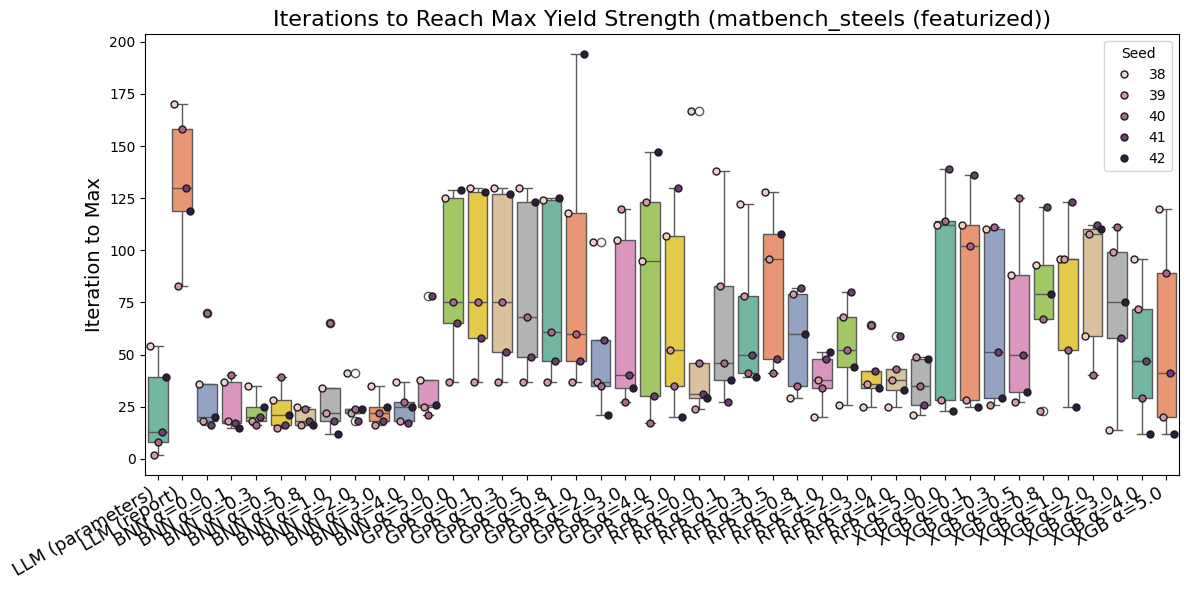

In [3]:
plot_iteration_to_max(data_dir="al_trajectory_data_all/matbench_steels (featurized)", dataset_name= "matbench_steels (featurized)", target_name="Yield Strength")

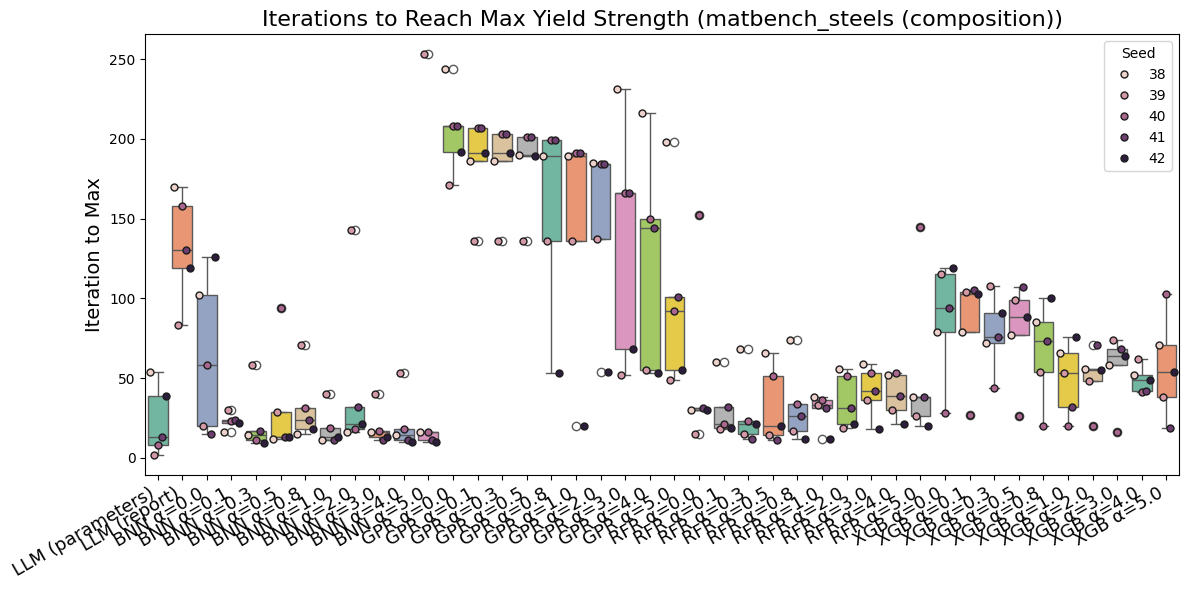

In [4]:
plot_iteration_to_max(data_dir="al_trajectory_data_all/matbench_steels (composition)", dataset_name= "matbench_steels (composition)", target_name="Yield Strength")

# P3HT

In [ ]:
data_grouped = pd.read_csv("P3HT_dataset.csv")
X_df = data_grouped.iloc[:, 0:5]
#X_df = data_grouped.iloc[:, 2:16]
y_df = data_grouped['Conductivity (measured) (S/cm)']

In [ ]:
for model_name in ["GPR", "RFR", "XGB", "BNN"]:
    for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
        for seed in [42, 41, 40, 39, 38]:
            run_MLAL(X_df, y_df, model_name=model_name, target_name="Conductivity", dataset_name="P3HT_dataset", alpha=alpha, random_seed=seed)

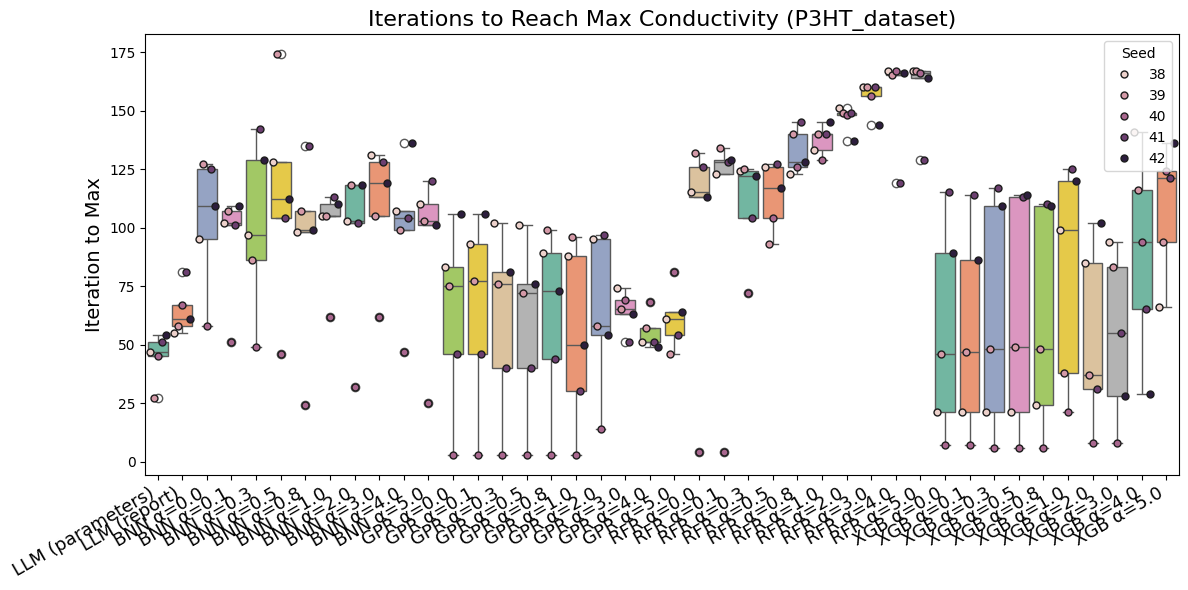

In [5]:
plot_iteration_to_max(data_dir="al_trajectory_data_all/P3HT_dataset", dataset_name= "P3HT_dataset", target_name="Conductivity")

# Perovskite

In [ ]:
data_grouped = pd.read_csv("Perovskite_dataset.csv")
X_df = data_grouped.iloc[:, 0:3]
#X_df = data_grouped.iloc[:, 2:16]
y_df = -data_grouped['Instability index']
y_df

In [ ]:
for model_name in ["GPR", "RFR", "XGB", "BNN"]:
    for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
        for seed in [42, 41, 40, 39, 38]:
            run_MLAL(X_df, y_df, model_name=model_name, target_name="-Instability index", dataset_name="Perovskite_dataset", alpha=alpha, random_seed=seed)

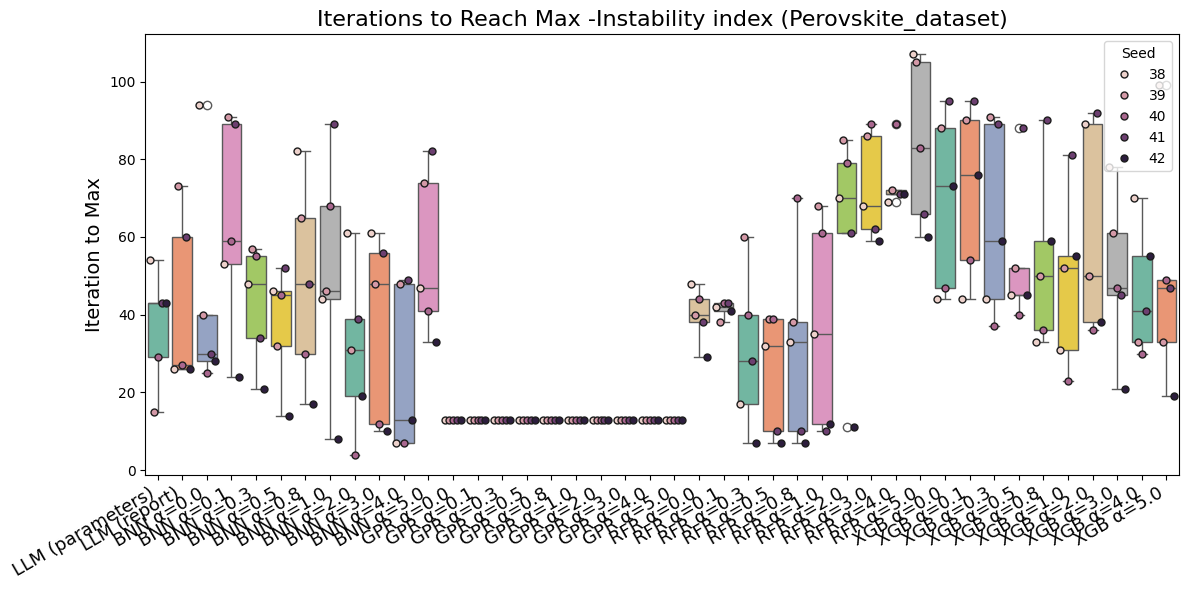

In [6]:
plot_iteration_to_max(data_dir="al_trajectory_data_all/Perovskite_dataset", dataset_name= "Perovskite_dataset", target_name="-Instability index")

# Membrane Dataset

In [ ]:
data_grouped = pd.read_csv('all_data_parameters_2024_11_26_forAL_grouped_2025_05_27.csv')
X_df = data_grouped.drop([
    'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
    'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
    'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
    'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date',
    'Average Standard Deviation_mean', 'Average Standard Deviation_std',
    'Coefficient of Variation_mean', 'Coefficient of Variation_std',
    'Coefficient of Variation', 'Batch', 'Sample', 'Index', 'Formatted_Parameters','Report','Report with output', 'Formatted_Parameters with output'], axis=1)
y_df = data_grouped['Elastic Modulus_mean']
X_df

In [ ]:
for model_name in ["GPR", "RFR", "XGB", "BNN"]:
    for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
        for seed in [42, 41, 40, 39, 38]:
            run_MLAL(X_df, y_df, model_name=model_name, target_name="Elastic Modulus", dataset_name="Membrane_dataset", alpha=alpha, random_seed=seed)

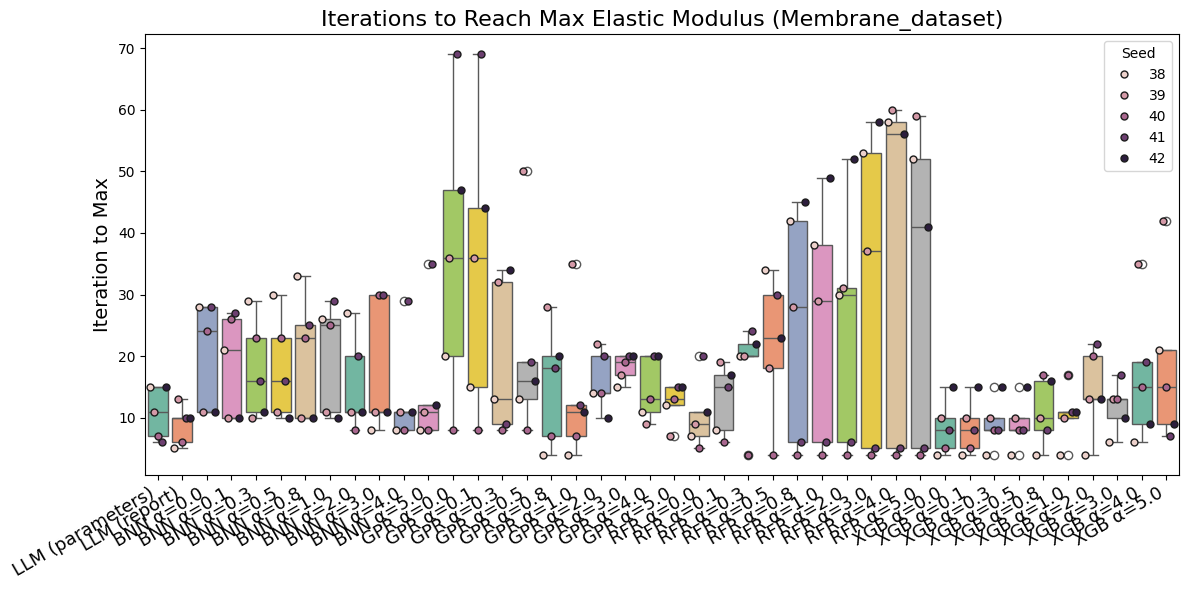

In [7]:
plot_iteration_to_max(data_dir="al_trajectory_data_all/Membrane_dataset", dataset_name= "Membrane_dataset", target_name="Elastic Modulus")